In [240]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import scipy.constants
from qutip import *
import random
from numpy.random import choice
import matplotlib.cm as cm
from sympy import *
from IPython.display import Image
from sympy.physics.wigner import wigner_6j
from sympy.physics.quantum.cg import CG
import tqdm
from numpy import random
from scipy.optimize import curve_fit

""" 
constants
"""
pi = np.pi
c = sp.constants.c
epsilon0 = sp.constants.epsilon_0
hbar = sp.constants.hbar
h = sp.constants.h
u = sp.constants.physical_constants['atomic mass constant'][0]
kB = sp.constants.physical_constants['Boltzmann constant'][0]
mB = sp.constants.physical_constants['Bohr magneton'][0]

# α/h [Hz/(V/m)2]=2.48832×10−8 α [a.u.] from https://arxiv.org/pdf/1507.06570.pdf
# α [a.u.] = 1.648 777 274 36 x 10-41 α [C2 m2 J-1] #https://physics.nist.gov/cgi-bin/cuu/Value?auepol
a_au = 1.64877727436*1e-41

In [241]:
#hyperfine reduced matrix element <F||d||F'>
def __Fg_d_Fe(Jg_d_Je, Fg, Fe, Jg, Je, I):
    return (
    Jg_d_Je * (-1)**(Fe+Jg+1+I) * 
        np.sqrt( (2*Fe+1)*(2*Jg+1) ) 
        * wigner_6j(Jg, Je, 1, Fe, Fg, I)
    )

In [242]:
#reduced matrix element <Jg||d||Je>
def __Jg_d_Je(omega_0, Jg, Je, tau):
    return np.sqrt(
        3*np.pi*epsilon0*hbar*c**3/omega_0**3/tau
        * (2*Je+1)/(2*Jg+1)
    )

In [243]:
def Rabi_clock(Fg, Fe, mg, me, d, pol, phi):
    q = -(me-mg)
    Jg_d_Je = d
    
    CG_coeff = float(CG(Fe, me, 1, q, Fg, mg).doit())
    
    Eplus = pol * np.sqrt( intensity / 2 / epsilon0 / c)
    
    return (
    -2 * Jg_d_Je / hbar * Eplus * CG_coeff*np.exp(-1j*phi)
    )
    

In [244]:
wH = 0.025e-3
wV = wH
P = 0.6*80e-3
intensity = 2*P/np.pi/wV/wH
d = 4.5*hbar

In [245]:
Rabi_clock(1/2, 1/2, 1/2, -1/2, 4.5*hbar,  1, 0)/1e6/2/np.pi

(0.1122374959289495+0j)

In [246]:
Rabi_clock(1/2, 1/2, 1/2, 1/2, 4.5*hbar,  1, 0)/1e6/2/np.pi

(-0.07936389447475771+0j)

In [247]:
print(float(CG(1/2, -1/2, 1, 1, 1/2, 1/2).doit()))
print(float(CG(1/2, 1/2, 1, -1, 1/2, -1/2).doit()))

-0.816496580927726
0.816496580927726


In [248]:
def cos_fit(t, f, phi):
    return -np.cos(2*np.pi*t*f+phi)*1/2+1/2

In [249]:
""" 
constants
"""
pi = np.pi
c = sp.constants.c
epsilon0 = sp.constants.epsilon_0
hbar = sp.constants.hbar
h = sp.constants.h
u = sp.constants.physical_constants['atomic mass constant'][0]
kB = sp.constants.physical_constants['Boltzmann constant'][0]
mB = sp.constants.physical_constants['Bohr magneton'][0]

# α/h [Hz/(V/m)2]=2.48832×10−8 α [a.u.] from https://arxiv.org/pdf/1507.06570.pdf
# α [a.u.] = 1.648 777 274 36 x 10-41 α [C2 m2 J-1] #https://physics.nist.gov/cgi-bin/cuu/Value?auepol
a_au = 1.64877727436*1e-41

In [250]:
_lambda = 578e-9
omega_r = 2*np.pi*9.4e3
m = 171*u
tau = 22

k = 2*np.pi/_lambda #momentum kick 
x0 = np.sqrt(hbar/2/m/omega_r) #oscillator length
LambDicke = x0*k #Lamb-Dicke parameters
print('Lamb-Dicke parameter (eta): ', LambDicke)
print('eta^2 (2n+1): ', LambDicke**2, '(2n+1)')
print('Max n for Lamb-Dicke regime: n = ', floor(((1/LambDicke**2)-1)/2))

Lamb-Dicke parameter (eta):  0.6095349993254959
eta^2 (2n+1):  0.3715329154027323 (2n+1)
Max n for Lamb-Dicke regime: n =  0


In [251]:
N=10 #keep HO states up to N 

one = basis(4,0)
two = basis(4,1)
three = basis(4,2)
four = basis(4,3)
ground = fock(N, 0)

a = qutip.tensor(destroy(N), identity(4))
adag = qutip.tensor(create(N), identity(4))

sig_11 = qutip.tensor(identity(N),one*one.dag())
sig_22 = qutip.tensor(identity(N),two*two.dag())
sig_33 = qutip.tensor(identity(N),three*three.dag())
sig_44 = qutip.tensor(identity(N),four*four.dag())

sig_14 = qutip.tensor(identity(N),one*four.dag())
sig_41 = qutip.tensor(identity(N),four*one.dag())

sig_13 = qutip.tensor(identity(N),one*three.dag())
sig_31 = qutip.tensor(identity(N),three*one.dag())

sig_24 = qutip.tensor(identity(N),two*four.dag())
sig_42 = qutip.tensor(identity(N),four*two.dag())

sig_23 = qutip.tensor(identity(N),two*three.dag())
sig_32 = qutip.tensor(identity(N),three*two.dag())

# MPP

In [13]:
psi0 = 1/np.sqrt(2)*(one+two)
ground_proj = qutip.tensor(ground*ground.dag(), identity(4))

In [14]:
T=0.86e-6 #initial temperature
omega_r_deep = 2*np.pi*58e3
n_start =1/(np.exp(hbar*omega_r_deep/T/kB)-1)
rho0 = qutip.tensor(thermal_dm(N, n_start), psi0*psi0.dag()) #start in up thermal state
print(isherm(rho0))
print('n_start: ', n_start)
print('ground state population', (rho0*ground_proj).tr())

True
n_start:  0.040900516094455636
ground state population 0.9607066040778716


In [15]:
B = 1.5e-4 #magnetic field in T
print('Magnetic field B', B*1e4, 'G')

delta_Ne = -2*np.pi*582*B*1e4 #excited
delta_Ng = -2*np.pi*375*B*1e4 #ground
Fg=1/2
Fe=1/2

Magnetic field B 1.4999999999999998 G


In [16]:
#diagonal terms
diag_1 = -delta_Ng

diag_2 = delta_Ng

diag_3 = -delta_Ne

diag_4 = delta_Ne

In [23]:
def R_theta_phi(rho, theta, phi):

    phase_pol = 3/180*np.pi
    angle_pol = 1/180*np.pi
    

    ## polarization ##
    ##################

    #basis
    x = np.array([1,0,0])
    y = np.array([0,1,0])
    z = np.array([0,0,1])

    polarization = (np.cos(angle_pol)*x+np.sin(angle_pol)*np.exp(-1j*phase_pol)*z)

    #spherical tensor
    pi_pol = x
    sigp_pol = 1/np.sqrt(2)*(-z-1j*y)
    sigm_pol = -1/np.sqrt(2)*(-z+1j*y)

    #off-diagonal terms
    offdiag_31 = Rabi_clock(Fg, Fe, -1/2, -1/2, d, np.dot(polarization, pi_pol), phi) / 2
    offdiag_41 = Rabi_clock(Fg, Fe, -1/2, 1/2, d, np.dot(polarization, sigp_pol), phi) / 2
    offdiag_32 = Rabi_clock(Fg, Fe, 1/2, -1/2, d, np.dot(polarization, sigm_pol), phi) / 2
    offdiag_42 = Rabi_clock(Fg, Fe, 1/2, 1/2, d, np.dot(polarization, pi_pol), phi) / 2

    offdiag_14 = np.conjugate(offdiag_41)
    offdiag_13 = np.conjugate(offdiag_31)
    offdiag_24 = np.conjugate(offdiag_42)
    offdiag_23 = np.conjugate(offdiag_32)

    H0 = (
    diag_1*sig_11 + diag_2*sig_22 + diag_3*sig_33 + diag_4*sig_44

     ) 
    
    t_ls = np.linspace(0, theta/abs(2*offdiag_31), 20)

    Hm = omega_r*(adag*a + 1/2)

    Hd = ( (1j*LambDicke*(adag+a)).expm()*(offdiag_13*sig_13 +  offdiag_14*sig_14 +
                                           offdiag_24*sig_24 + offdiag_23*sig_23)

         + (-1j*LambDicke*(adag+a)).expm()*(offdiag_31*sig_31 + offdiag_41*sig_41
                                            + offdiag_42*sig_42 + offdiag_32*sig_32) )

    H = H0 + Hm + Hd

    c_ops = []

    options = qutip.solver.Options(nsteps=100000)

    output = mesolve(H, rho, t_ls, c_ops, options=options, progress_bar=True)
    
    return output

In [24]:
output = R_theta_phi(rho0, 384.3/180*np.pi, 0)
rho1 = output.states[-1]
output = R_theta_phi(rho1, 318.6/180*np.pi, np.pi)
rho2 = output.states[-1]
output = R_theta_phi(rho2, 24.3/180*np.pi, 0)
rho3 = output.states[-1]
output = R_theta_phi(rho3, 384.3/180*np.pi, 0)
rho4 = output.states[-1]
output = R_theta_phi(rho4, 318.6/180*np.pi, np.pi)
rho5 = output.states[-1]
output = R_theta_phi(rho5, 24.3/180*np.pi, 0)
rho6 = output.states[-1]

10.0%. Run time:   0.00s. Est. time left: 00:00:00:00
20.0%. Run time:   0.01s. Est. time left: 00:00:00:00
30.0%. Run time:   0.01s. Est. time left: 00:00:00:00
40.0%. Run time:   0.01s. Est. time left: 00:00:00:00
50.0%. Run time:   0.01s. Est. time left: 00:00:00:00
60.0%. Run time:   0.01s. Est. time left: 00:00:00:00
70.0%. Run time:   0.01s. Est. time left: 00:00:00:00
80.0%. Run time:   0.01s. Est. time left: 00:00:00:00
90.0%. Run time:   0.01s. Est. time left: 00:00:00:00
Total run time:   0.02s
10.0%. Run time:   0.00s. Est. time left: 00:00:00:00
20.0%. Run time:   0.00s. Est. time left: 00:00:00:00
30.0%. Run time:   0.00s. Est. time left: 00:00:00:00
40.0%. Run time:   0.00s. Est. time left: 00:00:00:00
50.0%. Run time:   0.00s. Est. time left: 00:00:00:00
60.0%. Run time:   0.00s. Est. time left: 00:00:00:00
70.0%. Run time:   0.01s. Est. time left: 00:00:00:00
80.0%. Run time:   0.01s. Est. time left: 00:00:00:00
90.0%. Run time:   0.01s. Est. time left: 00:00:00:00
Tota

In [25]:
var_ls = np.linspace(0, 2*np.pi, 100)
P_ls = []
Pg_ls = []

for var in var_ls:

    psii = 1/np.sqrt(2)*(four+np.exp(-1j*var)*three)
    rhoi = psii*psii.dag()
    i_proj = qutip.tensor(identity(N), rhoi)

    P = (i_proj*rho6).tr()
    Pg = (ground_proj*rho6).tr()
    
    P_ls.append(abs(P))
    Pg_ls.append(abs(Pg))

print('max fidelity:', max(P_ls))
print('max ground state fraction:', max(Pg_ls))

max fidelity: 0.9995981909137289
max ground state fraction: 0.9588321543729137


max fidelity: 99.960 %


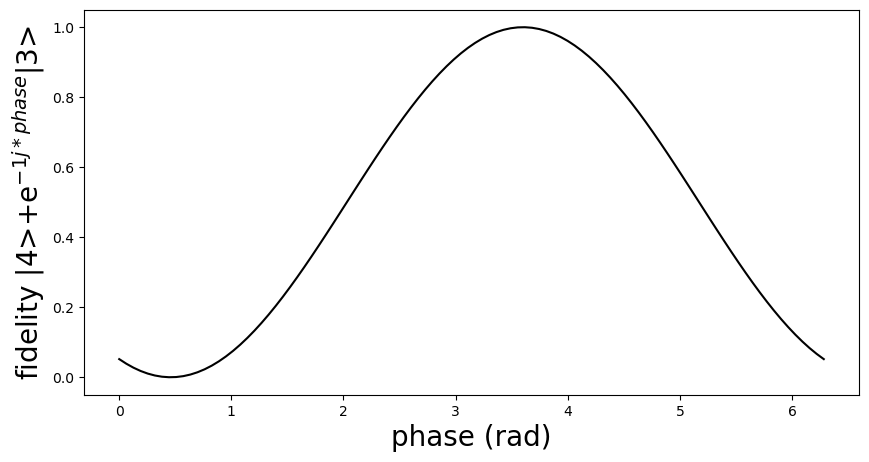

In [26]:
fig, axes = plt.subplots(1,1, dpi=100, sharex=True, figsize=(10,5))
axes.plot(var_ls, abs(np.array(P_ls)), color='k', linestyle='-', label = 'mF=-1/2')
axes.set_xlabel(r'phase (rad)', fontsize=20)
axes.set_ylabel(r'fidelity |4>+e$^{-1j*phase}$|3>', fontsize=20)
print('max fidelity: %.3f' %np.max(abs(np.array(P_ls))*100), '%')

#pi_time_idx = np.argwhere(abs(np.array(P))==np.max(abs(np.array(P))))
#pi_time = t_ls[pi_time_idx]

## as function of polarization impurity

In [237]:
phase_pol_ls = np.linspace(0, np.pi/4, 10)
angle_pol_ls = np.linspace(0, 0.5/180*np.pi, 10)

Ptot = []
Pgtot = []
i = 0
for phase_pol in phase_pol_ls:
    print(i)
    i+=1
    for angle_pol in angle_pol_ls:
        
        def R_theta_phi(rho, theta, phi, phase_pol, angle_pol):


            ## polarization ##
            ##################

            #basis
            x = np.array([1,0,0])
            y = np.array([0,1,0])
            z = np.array([0,0,1])

            polarization = (np.cos(angle_pol)*x+np.sin(angle_pol)*np.exp(-1j*phase_pol)*z)

            #spherical tensor
            pi_pol = x
            sigp_pol = 1/np.sqrt(2)*(-z-1j*y)
            sigm_pol = -1/np.sqrt(2)*(-z+1j*y)

            #off-diagonal terms
            offdiag_31 = Rabi_clock(Fg, Fe, -1/2, -1/2, d, np.dot(polarization, pi_pol), phi) / 2
            offdiag_41 = Rabi_clock(Fg, Fe, -1/2, 1/2, d, np.dot(polarization, sigp_pol), phi) / 2
            offdiag_32 = Rabi_clock(Fg, Fe, 1/2, -1/2, d, np.dot(polarization, sigm_pol), phi) / 2
            offdiag_42 = Rabi_clock(Fg, Fe, 1/2, 1/2, d, np.dot(polarization, pi_pol), phi) / 2

            offdiag_14 = np.conjugate(offdiag_41)
            offdiag_13 = np.conjugate(offdiag_31)
            offdiag_24 = np.conjugate(offdiag_42)
            offdiag_23 = np.conjugate(offdiag_32)

            H0 = (
            diag_1*sig_11 + diag_2*sig_22 + diag_3*sig_33 + diag_4*sig_44

             ) 

            t_ls = np.linspace(0, theta/abs(2*offdiag_31), 20)

            Hm = omega_r*(adag*a + 1/2)

            Hd = ( (1j*LambDicke*(adag+a)).expm()*(offdiag_13*sig_13 +  offdiag_14*sig_14 +
                                                   offdiag_24*sig_24 + offdiag_23*sig_23)

                 + (-1j*LambDicke*(adag+a)).expm()*(offdiag_31*sig_31 + offdiag_41*sig_41
                                                    + offdiag_42*sig_42 + offdiag_32*sig_32) )

            H = H0 + Hm + Hd

            c_ops = []

            options = qutip.solver.Options(nsteps=100000)

            output = mesolve(H, rho, t_ls, c_ops, options=options)

            return output
        
        rho = rho0
        for num in range(11):
            output = R_theta_phi(rho, 384.3/180*np.pi, 0, phase_pol, angle_pol)
            rho1 = output.states[-1]
            output = R_theta_phi(rho1, 318.6/180*np.pi, np.pi, phase_pol, angle_pol)
            rho2 = output.states[-1]
            output = R_theta_phi(rho2, 24.3/180*np.pi, 0, phase_pol, angle_pol)
            rho3 = output.states[-1]
            output = R_theta_phi(rho3, 384.3/180*np.pi, 0, phase_pol, angle_pol)
            rho4 = output.states[-1]
            output = R_theta_phi(rho4, 318.6/180*np.pi, np.pi, phase_pol, angle_pol)
            rho5 = output.states[-1]
            output = R_theta_phi(rho5, 24.3/180*np.pi, 0, phase_pol, angle_pol)
            rho6 = output.states[-1]
            rho = rho6

        var_ls = np.linspace(0, 2*np.pi, 100)
        P_ls = []
        Pg_ls = []

        for var in var_ls:

            psii = 1/np.sqrt(2)*(four+np.exp(-1j*var)*three)
            rhoi = psii*psii.dag()
            i_proj = qutip.tensor(identity(N), rhoi)

            P = (i_proj*rho6).tr()
            Pg = (ground_proj*rho6).tr()

            P_ls.append(abs(P))
            Pg_ls.append(abs(Pg))
            
        Ptot.append(max(P_ls))
        Pgtot.append(max(Pg_ls))


0


ValueError: All dimensions must be integers >= 0

In [62]:
result = np.array(Ptot).reshape(10, 10)

Text(0, 0.5, 'H/V pol phase (deg)')

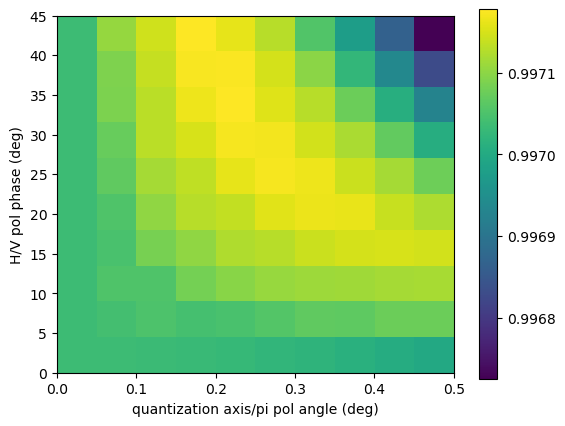

In [63]:
plt.imshow(result, extent = [min(angle_pol_ls)*180/np.pi, max(angle_pol_ls)*180/np.pi, min(phase_pol_ls)*180/np.pi, max(phase_pol_ls)*180/np.pi], aspect = 0.01, origin='lower')
plt.colorbar()
plt.xlabel('quantization axis/pi pol angle (deg)')
plt.ylabel('H/V pol phase (deg)')

In [114]:
phase_pol_ls = np.linspace(0, 90/180*np.pi, 30)
angle_pol = 0

Ptot = []
Pgtot = []
sigm_tot = []
sigp_tot = []
pi_tot = []
i = 0

for phase_pol in phase_pol_ls:
    
    ## polarization ##
    ##################

    #basis
    x = np.array([1,0,0])
    y = np.array([0,1,0])
    z = np.array([0,0,1])

    polarization = (np.cos(angle_pol)*x+np.sin(angle_pol)*np.exp(-1j*phase_pol)*z)
    
    #spherical tensor
    pi_pol = x
    sigp_pol = 1/np.sqrt(2)*(-z-1j*y)
    sigm_pol = -1/np.sqrt(2)*(-z+1j*y)

    def R_theta_phi(rho, theta, phi, phase_pol, angle_pol):



        #off-diagonal terms
        offdiag_31 = Rabi_clock(Fg, Fe, -1/2, -1/2, d, np.dot(polarization, pi_pol), phi) / 2
        offdiag_41 = Rabi_clock(Fg, Fe, -1/2, 1/2, d, np.dot(polarization, sigp_pol), phi) / 2
        offdiag_32 = Rabi_clock(Fg, Fe, 1/2, -1/2, d, np.dot(polarization, sigm_pol), phi) / 2
        offdiag_42 = Rabi_clock(Fg, Fe, 1/2, 1/2, d, np.dot(polarization, pi_pol), phi) / 2

        offdiag_14 = np.conjugate(offdiag_41)
        offdiag_13 = np.conjugate(offdiag_31)
        offdiag_24 = np.conjugate(offdiag_42)
        offdiag_23 = np.conjugate(offdiag_32)

        H0 = (
        diag_1*sig_11 + diag_2*sig_22 + diag_3*sig_33 + diag_4*sig_44

         ) 

        t_ls = np.linspace(0, theta/abs(2*offdiag_31), 20)

        Hm = omega_r*(adag*a + 1/2)

        Hd = ( (1j*LambDicke*(adag+a)).expm()*(offdiag_13*sig_13 +  offdiag_14*sig_14 +
                                               offdiag_24*sig_24 + offdiag_23*sig_23)

             + (-1j*LambDicke*(adag+a)).expm()*(offdiag_31*sig_31 + offdiag_41*sig_41
                                                + offdiag_42*sig_42 + offdiag_32*sig_32) )

        H = H0 + Hm + Hd

        c_ops = []

        options = qutip.solver.Options(nsteps=100000)

        output = mesolve(H, rho, t_ls, c_ops, options=options)

        return output

    rho = rho0
    for num in range(1):
        output = R_theta_phi(rho, 384.3/180*np.pi, 0, phase_pol, angle_pol)
        rho1 = output.states[-1]
        output = R_theta_phi(rho1, 318.6/180*np.pi, np.pi, phase_pol, angle_pol)
        rho2 = output.states[-1]
        output = R_theta_phi(rho2, 24.3/180*np.pi, 0, phase_pol, angle_pol)
        rho3 = output.states[-1]
        output = R_theta_phi(rho3, 384.3/180*np.pi, 0, phase_pol, angle_pol)
        rho4 = output.states[-1]
        output = R_theta_phi(rho4, 318.6/180*np.pi, np.pi, phase_pol, angle_pol)
        rho5 = output.states[-1]
        output = R_theta_phi(rho5, 24.3/180*np.pi, 0, phase_pol, angle_pol)
        rho6 = output.states[-1]
        rho = rho6

    var_ls = np.linspace(0, 2*np.pi, 100)
    P_ls = []
    Pg_ls = []

    for var in var_ls:

        psii = 1/np.sqrt(2)*(four+np.exp(-1j*var)*three)
        rhoi = psii*psii.dag()
        i_proj = qutip.tensor(identity(N), rhoi)

        P = (i_proj*rho6).tr()
        Pg = (ground_proj*rho6).tr()

        P_ls.append(abs(P))
        Pg_ls.append(abs(Pg))

    Ptot.append(max(P_ls))
    Pgtot.append(max(Pg_ls))
    
    sigm_tot.append(np.dot(polarization, sigm_pol))
    sigp_tot.append(np.dot(polarization, sigp_pol))
    pi_tot.append(np.dot(polarization, pi_pol))
    


In [115]:
result = np.array(Ptot)

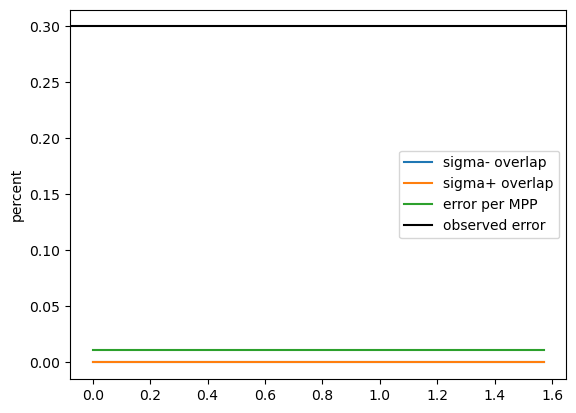

In [116]:
plt.plot(phase_pol_ls, abs(np.array(sigm_tot))*100, label='sigma- overlap')
plt.plot(phase_pol_ls, abs(np.array(sigp_tot))*100, label='sigma+ overlap')
#plt.plot(angle_pol_ls, pi_tot)
plt.plot(phase_pol_ls, (1-result)*100, label='error per MPP')
#plt.ylim(0, 0.3)
plt.axhline(0.3, c='k', label='observed error')
plt.ylabel('percent')
plt.legend()

In [82]:
np.dot(polarization, sigm_pol)

(3.773652163401863e-18-0.061628416716219346j)

Text(0, 0.5, 'H/V pol phase (deg)')

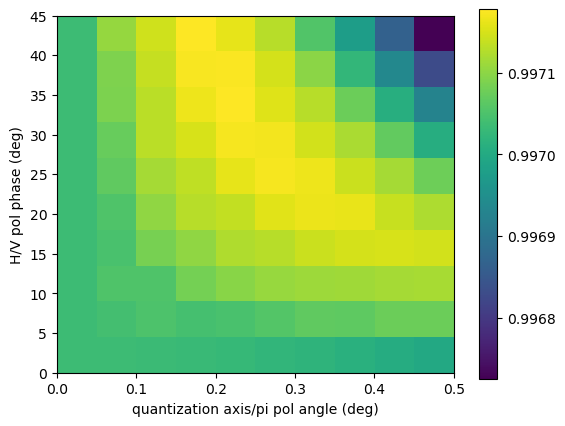

In [63]:
plt.imshow(result, extent = [min(angle_pol_ls)*180/np.pi, max(angle_pol_ls)*180/np.pi, min(phase_pol_ls)*180/np.pi, max(phase_pol_ls)*180/np.pi], aspect = 0.01, origin='lower')
plt.colorbar()
plt.xlabel('quantization axis/pi pol angle (deg)')
plt.ylabel('H/V pol phase (deg)')

# as a function of Rabi

In [252]:
psi0 = 1/np.sqrt(2)*(one+two)
ground_proj = qutip.tensor(ground*ground.dag(), identity(4))

In [253]:
T=0.86e-6 #initial temperature
omega_r_deep = 2*np.pi*58e3
n_start =1/(np.exp(hbar*omega_r_deep/T/kB)-1)
rho0 = qutip.tensor(thermal_dm(N, n_start), psi0*psi0.dag()) #start in up thermal state
print(isherm(rho0))
print('n_start: ', n_start)
print('ground state population', (rho0*ground_proj).tr())

True
n_start:  0.040900516094455636
ground state population 0.9607066040778716


In [254]:
B = 1.5e-4 #magnetic field in T
print('Magnetic field B', B*1e4, 'G')

delta_Ne = -2*np.pi*582*B*1e4 #excited
delta_Ng = -2*np.pi*375*B*1e4 #ground
Fg=1/2
Fe=1/2

Magnetic field B 1.4999999999999998 G


In [255]:
#diagonal terms
diag_1 = -delta_Ng

diag_2 = delta_Ng

diag_3 = -delta_Ne

diag_4 = delta_Ne

In [256]:
scale = np.linspace(0.5, 3.5, 200)
Ptot = []
Pgtot = []
nbartot = []
poptot = []

for s in scale:
    
    def R_theta_phi(rho, theta, phi):

        phase_pol = 0
        angle_pol = 0


        ## polarization ##
        ##################

        #basis
        x = np.array([1,0,0])
        y = np.array([0,1,0])
        z = np.array([0,0,1])

        polarization = (np.cos(angle_pol)*x+np.sin(angle_pol)*np.exp(-1j*phase_pol)*z)

        #spherical tensor
        pi_pol = x
        sigp_pol = 1/np.sqrt(2)*(-z-1j*y)
        sigm_pol = -1/np.sqrt(2)*(-z+1j*y)

        #off-diagonal terms
        offdiag_31 = s*Rabi_clock(Fg, Fe, -1/2, -1/2, d, np.dot(polarization, pi_pol), phi) / 2
        offdiag_41 = s*Rabi_clock(Fg, Fe, -1/2, 1/2, d, np.dot(polarization, sigp_pol), phi) / 2
        offdiag_32 = s*Rabi_clock(Fg, Fe, 1/2, -1/2, d, np.dot(polarization, sigm_pol), phi) / 2
        offdiag_42 = s*Rabi_clock(Fg, Fe, 1/2, 1/2, d, np.dot(polarization, pi_pol), phi) / 2

        offdiag_14 = np.conjugate(offdiag_41)
        offdiag_13 = np.conjugate(offdiag_31)
        offdiag_24 = np.conjugate(offdiag_42)
        offdiag_23 = np.conjugate(offdiag_32)

        H0 = (
        diag_1*sig_11 + diag_2*sig_22 + diag_3*sig_33 + diag_4*sig_44

         ) 

        t_ls = np.linspace(0, theta/abs(2*offdiag_31), 20)

        Hm = omega_r*(adag*a + 1/2)

        Hd = ( (1j*LambDicke*(adag+a)).expm()*(offdiag_13*sig_13 +  offdiag_14*sig_14 +
                                               offdiag_24*sig_24 + offdiag_23*sig_23)

             + (-1j*LambDicke*(adag+a)).expm()*(offdiag_31*sig_31 + offdiag_41*sig_41
                                                + offdiag_42*sig_42 + offdiag_32*sig_32) )

        H = H0 + Hm + Hd

        c_ops = []

        options = qutip.solver.Options(nsteps=100000)

        output = mesolve(H, rho, t_ls, c_ops, options=options)

        return output
    
    output = R_theta_phi(rho0, 384.3/180*np.pi, 0)
    rho1 = output.states[-1]
    output = R_theta_phi(rho1, 318.6/180*np.pi, np.pi)
    rho2 = output.states[-1]
    output = R_theta_phi(rho2, 24.3/180*np.pi, 0)
    rho3 = output.states[-1]
    output = R_theta_phi(rho3, 384.3/180*np.pi, 0)
    rho4 = output.states[-1]
    output = R_theta_phi(rho4, 318.6/180*np.pi, np.pi)
    rho5 = output.states[-1]
    output = R_theta_phi(rho5, 24.3/180*np.pi, 0)
    rho6 = output.states[-1]
    
    var_ls = np.linspace(0, 2*np.pi, 500)
    P_ls = []
    Pg_ls = []
    nbar_ls = []
    pop_ls = []

    for var in var_ls:

        psii = 1/np.sqrt(2)*(four+np.exp(-1j*var)*three)
        rhoi = psii*psii.dag()
        i_proj = qutip.tensor(identity(N), rhoi)
        three_proj = qutip.tensor(identity(N), three*three.dag())
        four_proj = qutip.tensor(identity(N), four*four.dag())

        P = (i_proj*rho6).tr()
        Pg = (ground_proj*rho6).tr()
        nbar = (adag*a*rho6).tr()
        pop = (three_proj*rho6+four_proj*rho6).tr()

        P_ls.append(abs(P))
        Pg_ls.append(abs(Pg))
        nbar_ls.append(abs(nbar))
        pop_ls.append(abs(pop))
    
    Ptot.append(max(P_ls))
    Pgtot.append(max(Pg_ls))
    nbartot.append(min(nbar_ls))
    poptot.append(max(pop_ls))

(1e-05, 0.05)

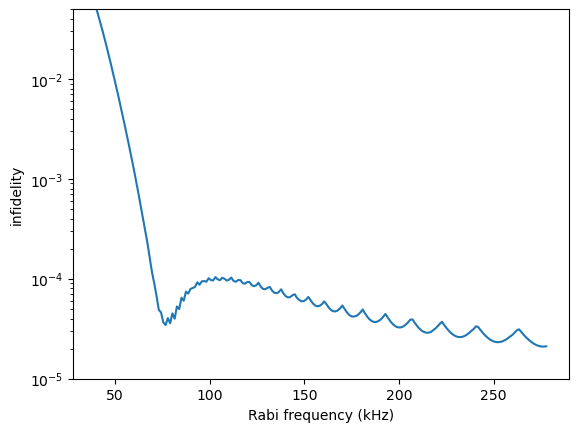

In [257]:
plt.semilogy(scale*Rabi_clock(Fg, Fe, -1/2, -1/2, d, np.dot(polarization, pi_pol), 0)/2/np.pi/1e3, 1-np.array(Ptot))
plt.xlabel('Rabi frequency (kHz)')
plt.ylabel('infidelity')
plt.ylim(1e-5, 5e-2)

(0.6, 1.0)

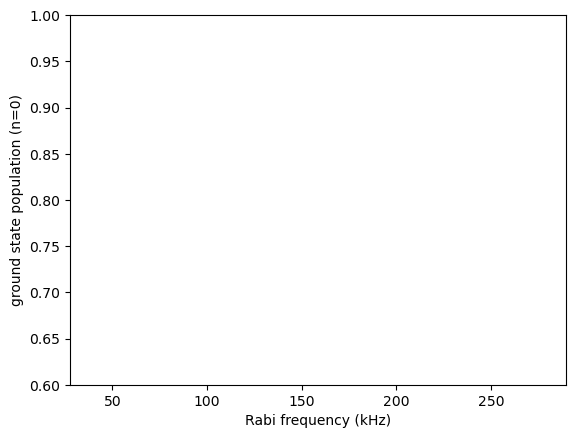

In [224]:
plt.plot(scale*Rabi_clock(Fg, Fe, -1/2, -1/2, d, np.dot(polarization, pi_pol), 0)/2/np.pi/1e3, np.array(Pgtot))
plt.xlabel('Rabi frequency (kHz)')
plt.ylabel('ground state population (n=0)')
plt.ylim(0.6, 1)

(0.0, 0.35)

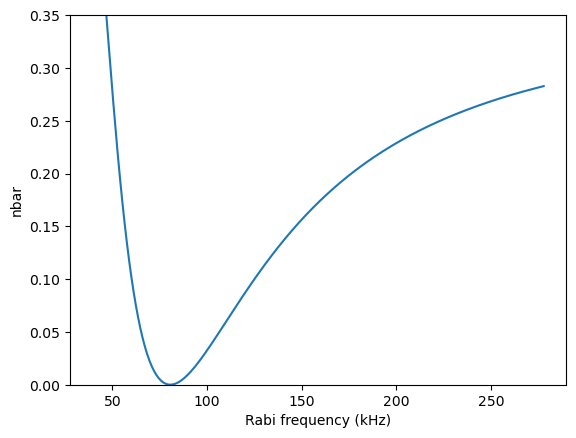

In [204]:
plt.plot(scale*Rabi_clock(Fg, Fe, -1/2, -1/2, d, np.dot(polarization, pi_pol), 0)/2/np.pi/1e3, np.array(nbartot))
plt.xlabel('Rabi frequency (kHz)')
plt.ylabel('nbar')
plt.ylim(0, 0.35)

(1e-05, 0.09781361616778719)

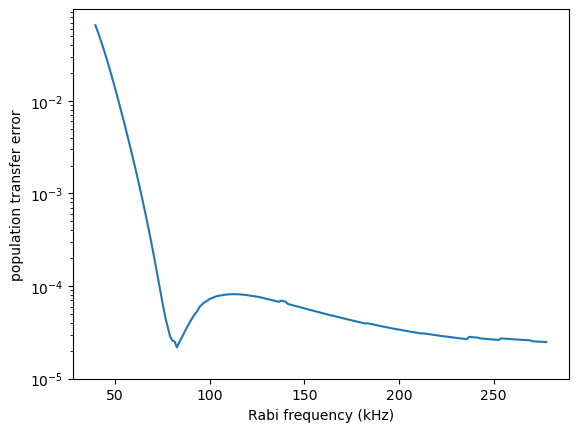

In [206]:
plt.semilogy(scale*Rabi_clock(Fg, Fe, -1/2, -1/2, d, np.dot(polarization, pi_pol), 0)/2/np.pi/1e3, 1-np.array(poptot))
plt.xlabel('Rabi frequency (kHz)')
plt.ylabel('population transfer error')
plt.ylim(1e-5,)